Načítám efemeridy DE421...
Generuji data pro lunární cyklus...


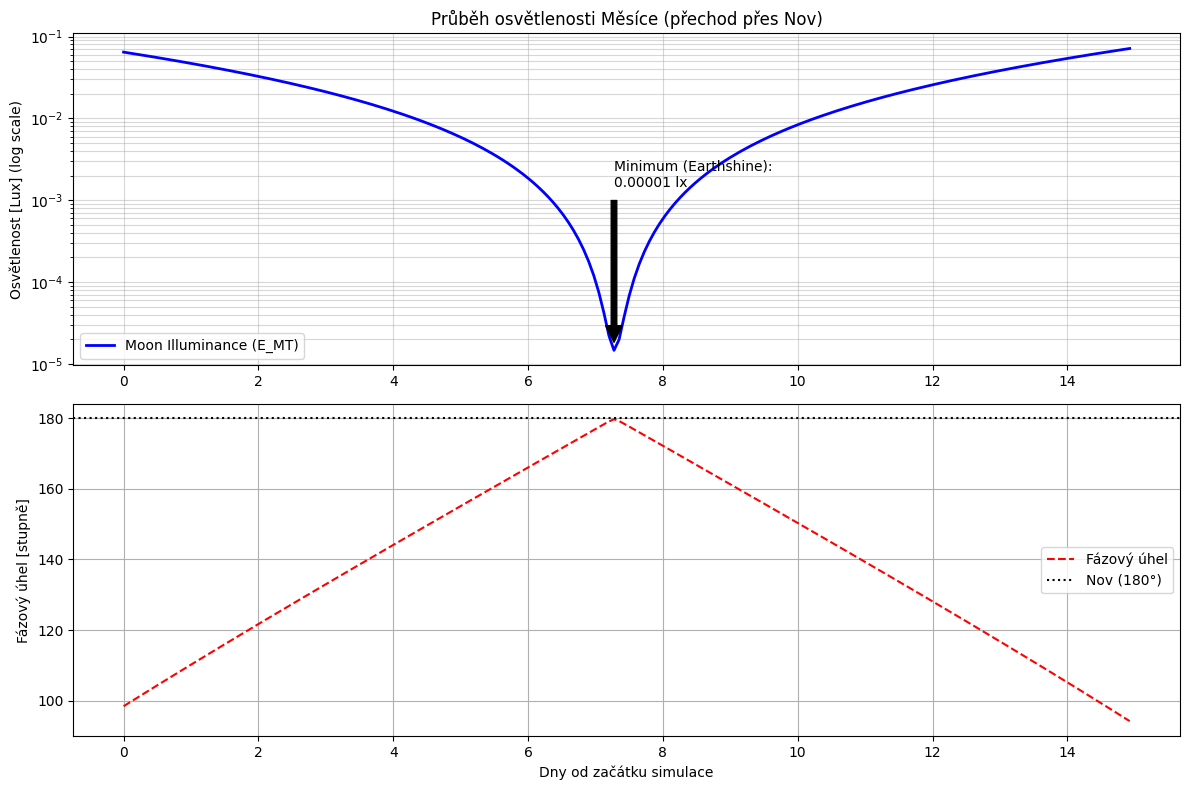

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Přidání cesty k src, abychom mohli importovat náš balíček
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

from illumination_model.astrometry import AstrometryEngine
from illumination_model.sources.moon import MoonModel

# 1. Inicializace modelu
engine = AstrometryEngine()
moon = MoonModel(engine)

# 2. Nastavení časového okna (Jeden měsíc kolem Novu)
# Vybereme datum blízko novu (např. 2. října 2024), abychom viděli minimum uprostřed
start_date = engine.get_time_from_utc(2024, 9, 25, 12, 0, 0)
days_to_simulate = 15
steps = 200  # Počet vzorků

times = []
illuminances = []
phases_deg = []
dates_axis = []

print("Generuji data pro lunární cyklus...")

for i in range(steps):
    # Posun v čase
    delta_days = (i / steps) * days_to_simulate
    # Vytvoření nového času (Skyfield Time objekt nemá přímé přičítání float dnů jednoduše, 
    # uděláme to přes TS objekt)
    t = engine.ts.tt_jd(start_date.tt + delta_days)
    
    # A) Výpočet osvětlenosti (Lux)
    lux = moon.get_extraterrestrial_illuminance(t)
    
    # B) Výpočet fáze (Stupně)
    phase_rad = moon.calculate_phase_angle(t)
    phase_deg = np.degrees(phase_rad)
    
    illuminances.append(lux)
    phases_deg.append(phase_deg)
    dates_axis.append(delta_days)

# 3. Vizualizace - Logaritmická škála (Klíčové pro Earthshine!)
plt.figure(figsize=(12, 8))

# Graf 1: Osvětlenost (Log Scale)
plt.subplot(2, 1, 1)
plt.plot(dates_axis, illuminances, 'b-', linewidth=2, label='Moon Illuminance (E_MT)')
plt.yscale('log')  # Logaritmická osa Y je nutná, jinak Earthshine neuvidíme
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.ylabel('Osvětlenost [Lux] (log scale)')
plt.title('Průběh osvětlenosti Měsíce (přechod přes Nov)')
plt.legend()

# Přidání textové poznámky k minimu
min_lux = min(illuminances)
min_idx = illuminances.index(min_lux)
plt.annotate(f'Minimum (Earthshine):\n{min_lux:.5f} lx', 
             xy=(dates_axis[min_idx], min_lux), 
             xytext=(dates_axis[min_idx], min_lux * 100),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Graf 2: Fázový úhel
plt.subplot(2, 1, 2)
plt.plot(dates_axis, phases_deg, 'r--', label='Fázový úhel')
plt.ylabel('Fázový úhel [stupně]')
plt.xlabel('Dny od začátku simulace')
plt.axhline(180, color='k', linestyle=':', label='Nov (180°)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()